# Q-Learning with Neural Network for FrozenLake-v0
 using a one-layer network which takes the state encoded in a one-hot vector (1x16), and produces a vector of 4 Q-values, one for each action. Maintaining the Q-vaules by Neural Network.
reference: https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0

In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make('FrozenLake-v0')

[2017-05-08 11:50:16,652] Making new env: FrozenLake-v0


In [3]:
state_num = env.observation_space.n #total state number
action_num = env.action_space.n #total action number
lr = 0.01

In [4]:
#Clears the default graph stack and resets the global default graph.
tf.reset_default_graph()

In [5]:
#These lines establish the feed-forward part of the network used to choose actions
input_ = tf.placeholder(tf.float32, [1, state_num])
W = tf.Variable(tf.random_uniform([state_num, action_num],0,0.01))
Qout = tf.matmul(input_, W) #Qout is the Q-values vector
predict = tf.argmax(Qout, 1) #find the most possibility action for the next action.

In [6]:
#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
target_ = tf.placeholder(tf.float32,[1, action_num])
loss = tf.reduce_sum(tf.square(target_-Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(loss)

### Train Network

In [7]:
# training the agent for one epcho
def trainAgent(sess, state_inputs, jList, rList, lossList, y, e):
    #Reset environment and get first new observation
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    #The Q-network
    while j<999:
        j+=1
        #Choose an action by greedily (with e chance of random action) from the Q-network
        a, allQ_vals= sess.run([predict, Qout], feed_dict={input_:[state_inputs[s]]})
        if np.random.rand(1) < e:
            a[0] = env.action_space.sample()
        #Get new state and reward from environment
        s1,r,d,_ = env.step(a[0])
        #Obtain the Q' values by feeding the new state through our network
        Q1 = sess.run(Qout,feed_dict={input_:[state_inputs[s1]]})
        #Obtain maxQ' and set our target value for chosen action.
        maxQ1 = np.max(Q1)
        targetQ = allQ_vals
        targetQ[0,a] = r + y*maxQ1 #note that loss is only applied for action "a".
        _, loss_val = sess.run([trainer, loss], feed_dict={input_:[state_inputs[s]], target_:targetQ})
        lossList.append(loss_val)
        rAll += r #record all rewords
        s = s1 #set state for next action.

        if d == True:
            #Reduce chance of random action as we train the model.
            e = 1./((i/50) + 10)
            break

    jList.append(j)
    rList.append(rAll)

In [8]:
# save and restore trained model
saver = tf.train.Saver()
chk_file_path = "checkpoints/Q-learning-nn.ckpt"

In [9]:
# Set learning parameters
num_episodes = 15000
y = .99
e = 0.1 

In [10]:
#create lists to contain total rewards and steps per episode
jList = []
rList = []
lossList = []
init = tf.initialize_all_variables()
with tf.Session() as sess:
    state_inputs = np.identity(16) #input data which is also states
    sess.run(init)
    for i in range(num_episodes):
        trainAgent(sess, state_inputs, jList, rList, lossList, y, e);
    #save trained model
    saver.save(sess, chk_file_path)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


[2017-05-08 11:50:17,405] From <ipython-input-10-95324375755e>:5: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


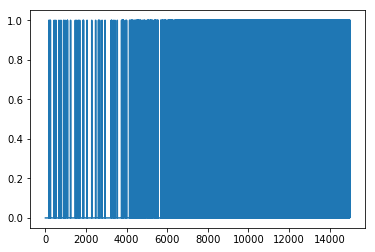

In [11]:
plt.plot(rList) # the more last, the better result to the destination

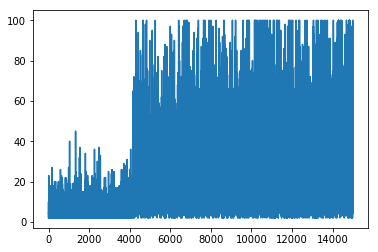

In [12]:
plt.plot(jList)

## Test Agent
if you already saved training model, you can skip training step and directly start testing

In [32]:
#Reset environment and get first new observation
def testAgent(sess):
    state_inputs = np.identity(16) #input data which is also states
    s = env.reset()
    d = False
    j = 0
    steps = []
    #The Q-network
    while j<999:
        #env.render() #uncomment this line to show the game simulator
        j+=1
        #Choose an action by greedily (with e chance of random action) from the Q-network
        a= sess.run(predict, feed_dict={input_:[state_inputs[s]]})
        #Get new state and reward from environment
        s1,r,d,_ = env.step(a[0])
        steps.append((s,s1,a[0]))
        s = s1 #set state for next action.
        if d == True:
            #print(s1, r, d)
            #print(steps)
            break
    return r

In [33]:
rewards = []
with tf.Session() as sess:    
    saver.restore(sess, chk_file_path)
    for i in range(1000):
        r = testAgent(sess)
        rewards.append(r)
    score = sum(rewards)/1000
    print(score)

0.704
